## Importing The necessary Libraries and Downloading the Dataset

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import os
import numpy as np
%matplotlib inline
plt.style.use("ggplot")

In [2]:
!gdown --id 1UCGzcV5ZTC51ShC8hFrE2esC-MdlvRn- 
!gdown --id 1bu048J7cfuNJpcIlJO2_KIg_tY3IX7p8

Downloading...
From: https://drive.google.com/uc?id=1UCGzcV5ZTC51ShC8hFrE2esC-MdlvRn-
To: /content/Fresh.zip
172MB [00:01, 89.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bu048J7cfuNJpcIlJO2_KIg_tY3IX7p8
To: /content/Withered.zip
230MB [00:02, 107MB/s] 


In [3]:
import zipfile
local_zip = '/content/Fresh.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/content')
zip_ref.close()

local_zip = '/content/Withered.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/content')
zip_ref.close()

## MODEL: An enesemble of MobileNetV23, Xception, NASNetMobile and DenseNet121 
We use ImageNet pre-trained models to make use of Transfer Learning and get a better idea of vision through these models

In [4]:
model1 = tf.keras.applications.MobileNetV3Large(input_shape=(224,224,3), include_top=False, weights="imagenet", pooling = 'avg') 
M1 = tf.keras.models.Sequential([
                                 model1,
                                 tf.keras.layers.Dense(3, activation='softmax')
])
model2 = tf.keras.applications.Xception(input_shape=(224,224,3), include_top=False, weights="imagenet", pooling = 'avg')
M2 = tf.keras.models.Sequential([
                                 model2,
                                 tf.keras.layers.Dense(3, activation='softmax')
])
model3 = tf.keras.applications.NASNetMobile(input_shape=(224,224,3), include_top=False, weights="imagenet", pooling = 'max')
M3 = tf.keras.models.Sequential([
                                 model3,
                                 tf.keras.layers.Dense(3, activation='softmax')
])
model4 = tf.keras.applications.DenseNet121(input_shape=(224,224,3), include_top=False, weights="imagenet", pooling = 'max')
M4 = tf.keras.models.Sequential([
                                 model4,
                                 tf.keras.layers.Dense(3, activation='softmax')
])


29097984/29084464 [==============================] - 0s 0us/step


In [5]:
x = tf.keras.layers.concatenate([M1.output,M2.output,M3.output, M4.output])
#x = tf.keras.layers.Dense(8, activation='leaky_relu')(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)
M = tf.keras.Model([M1.input,M2.input,M3.input, M4.input], x)

In [6]:
M.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
MobilenetV3large_input (InputLa [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
xception_input (InputLayer)     [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
NASNet_input (InputLayer)       [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
densenet121_input (InputLayer)  [(None, 224, 224, 3) 0                                            
______________________________________________________________________________________________

In [8]:
# MODEL.summary()

## FRESH Data Training and Validation: 
Using Necessary Data Augmentation and DataGenerator to test the model

In [9]:
print(len(os.listdir('/content/Fresh/Below Best')))
print(len(os.listdir('/content/Fresh/Best')))
print(len(os.listdir('/content/Fresh/Poor')))

73
153
43


clearly, the data imbalance poses threat to the model learnings. Thus, we can either remove the extra data by random sampling method or add data for a specific class to match the size  
We choose the latter and increase data for each class such that model generalizes better. We use total of `7` augmentations which are used later for Withered Leaves also.

1.   1 augmentation for class `Below Best` to get 438 images
2.   2 augmentation for class `Poor` to get 344 images 
3.   2 augmentation for class `Best` to get 459 images
wee use imgaug to make these augmentations



In [10]:
import imgaug as ia
import imgaug.augmenters as iaa
ia.seed(2)

seq1 = iaa.Sequential([
    iaa.Fliplr(1.0), 
    iaa.Flipud(0.7)
])

seq2 = iaa.Sequential([
    iaa.Affine(rotate=(-60, 60)),
    iaa.Flipud(1.0)
])

seq3 = iaa.PerspectiveTransform(scale=(0.01, 0.15))
seq4 = iaa.Affine(scale=(0.5, 1.5))
seq5 = iaa.LinearContrast((0.4, 1.6))
seq6 = iaa.Sequential([
    iaa.Flipud(1.0), 
    iaa.AllChannelsHistogramEqualization()
])
seq7 = iaa.LogContrast(gain=(0.6, 1.4))

# we use tha above defined augmentations 

'''augmenting the "Best" class:'''

from PIL import Image

count = 0
for i in os.listdir('/content/Fresh/Best'):
    img = Image.open(os.path.join("/content/Fresh/Best",i))
    img = np.array(img)
    
    img1 = seq6(image=img)
    img1 = Image.fromarray(np.uint8(img1)).convert('RGB')
    img1.save("/content/Fresh/Best/img_{}.jpg".format(count))
    count += 1

    img5 = seq3(image=img)
    img5 = Image.fromarray(np.uint8(img5)).convert('RGB')
    img5.save("/content/Fresh/Best/img_{}.jpg".format(count))
    count += 1


'''augmenting the "Below Best" class:'''
count = 0
for i in os.listdir('/content/Fresh/Below Best'):
    img = Image.open(os.path.join("/content/Fresh/Below Best",i))
    img = np.array(img)
    
    img1 = seq2(image=img)
    img1 = Image.fromarray(np.uint8(img1)).convert('RGB')
    img1.save("/content/Fresh/Below Best/img_{}.jpg".format(count))
    count += 1

    img4 = seq4(image=img)
    img4 = Image.fromarray(np.uint8(img4)).convert('RGB')
    img4.save("/content/Fresh/Below Best/img_{}.jpg".format(count))
    count += 1

    img5 = seq5(image=img)
    img5 = Image.fromarray(np.uint8(img5)).convert('RGB')
    img5.save("/content/Fresh/Below Best/img_{}.jpg".format(count))
    count += 1

    img6 = seq6(image=img)
    img6 = Image.fromarray(np.uint8(img6)).convert('RGB')
    img6.save("/content/Fresh/Below Best/img_{}.jpg".format(count))
    count += 1

    img7 = seq7(image=img)
    img7 = Image.fromarray(np.uint8(img7)).convert('RGB')
    img7.save("/content/Fresh/Below Best/img_{}.jpg".format(count))
    count += 1

'''augmenting the "Poor" class:'''
count = 0
for i in os.listdir('/content/Fresh/Poor'):
    img = Image.open(os.path.join("/content/Fresh/Poor",i))
    img = np.array(img)

    img1 = seq2(image=img)
    img1 = Image.fromarray(np.uint8(img1)).convert('RGB')
    img1.save("/content/Fresh/Poor/img_{}.jpg".format(count))
    count += 1

    img2 = seq1(image=img)
    img2 = Image.fromarray(np.uint8(img2)).convert('RGB')
    img2.save("/content/Fresh/Poor/img_{}.jpg".format(count))
    count += 1

    img3 = seq3(image=img)
    img3 = Image.fromarray(np.uint8(img3)).convert('RGB')
    img3.save("/content/Fresh/Poor/img_{}.jpg".format(count))
    count += 1

    img4 = seq4(image=img)
    img4 = Image.fromarray(np.uint8(img4)).convert('RGB')
    img4.save("/content/Fresh/Poor/img_{}.jpg".format(count))
    count += 1

    img5 = seq5(image=img)
    img5 = Image.fromarray(np.uint8(img5)).convert('RGB')
    img5.save("/content/Fresh/Poor/img_{}.jpg".format(count))
    count += 1

    img6 = seq6(image=img)
    img6 = Image.fromarray(np.uint8(img6)).convert('RGB')
    img6.save("/content/Fresh/Poor/img_{}.jpg".format(count))
    count += 1

    img7 = seq7(image=img)
    img7 = Image.fromarray(np.uint8(img7)).convert('RGB')
    img7.save("/content/Fresh/Poor/img_{}.jpg".format(count))
    count += 1

print(len(os.listdir('/content/Fresh/Below Best')))
print(len(os.listdir('/content/Fresh/Best')))
print(len(os.listdir('/content/Fresh/Poor')))

438
459
344


In [11]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    zoom_range=0.25,
    shear_range=0.3,
    validation_split=0.2,
)

train_generator = datagen.flow_from_directory(
        '/content/Fresh',
        target_size=(224, 224),
        batch_size=8,
        subset='training',
        class_mode='categorical')
validation_generator = datagen.flow_from_directory(
        '/content/Fresh',
        target_size=(224, 224),
        batch_size=8,
        subset='validation',
        class_mode='categorical')

Found 995 images belonging to 3 classes.
Found 246 images belonging to 3 classes.


In [19]:
# out = train_generator.next()
# a,b = out
# print(a.shape)
# print(b)

In [12]:
x,y = train_generator[0]
print(x.shape)
print(y.shape)

(8, 224, 224, 3)
(8, 3)


since the ensemble takes 3 inputs we define our custom datagenerator to get the three inputs for out ensemble model

[reference](https://stackoverflow.com/questions/59492866/keras-imagedatagenerator-for-multiple-inputs-and-image-based-target-output)


In [13]:
class Customed_datagen(tf.keras.utils.Sequence):
    def __init__(self, input_gen):
        self.gen = input_gen

    def __len__(self):
        return len(self.gen)

    def __getitem__(self, i):
        x,y = self.gen[i]
        return [x, x, x, x], y
    
    def y_val(self):
        return self.gen.classes
    
    def on_epoch_end(self):
        self.gen.on_epoch_end()
    
trainer = Customed_datagen(train_generator)
validator = Customed_datagen(validation_generator)

In [15]:
M.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])
history = M.fit(trainer, validation_data= validator, epochs = 20)

Epoch 1/20
125/125 [==============================] - 128s 585ms/step - loss: 0.8671 - accuracy: 0.5719 - val_loss: 0.8970 - val_accuracy: 0.5041
Epoch 2/20
125/125 [==============================] - 64s 513ms/step - loss: 0.7059 - accuracy: 0.6673 - val_loss: 0.8158 - val_accuracy: 0.6748
Epoch 3/20
125/125 [==============================] - 64s 512ms/step - loss: 0.6619 - accuracy: 0.7005 - val_loss: 0.7900 - val_accuracy: 0.6911
Epoch 4/20
125/125 [==============================] - 64s 510ms/step - loss: 0.6002 - accuracy: 0.7347 - val_loss: 0.7409 - val_accuracy: 0.7073
Epoch 5/20
125/125 [==============================] - 64s 510ms/step - loss: 0.5577 - accuracy: 0.7910 - val_loss: 0.6587 - val_accuracy: 0.8252
Epoch 6/20
125/125 [==============================] - 64s 508ms/step - loss: 0.5283 - accuracy: 0.8181 - val_loss: 0.6928 - val_accuracy: 0.7520
Epoch 7/20
125/125 [==============================] - 64s 510ms/step - loss: 0.5117 - accuracy: 0.8332 - val_loss: 0.6824 - val_a

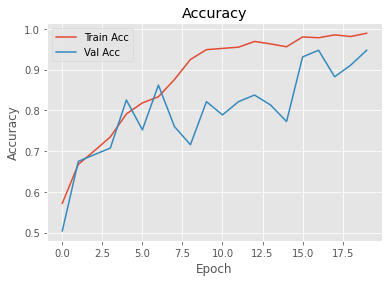

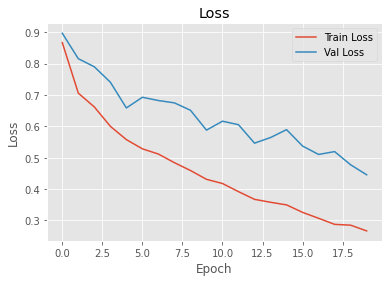

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Acc', 'Val Acc'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Val Loss'])
plt.show()

### Evaluating Results: 

In [18]:
validation_generator.class_indices

{'Below Best': 0, 'Best': 1, 'Poor': 2}

In [34]:
val_gen = datagen.flow_from_directory(
        '/content/Fresh',
        target_size=(224, 224),
        batch_size=246,
        subset='validation',
        class_mode='categorical')

Found 246 images belonging to 3 classes.


In [35]:
val_g = Customed_datagen(val_gen)
x,y = val_g[0]

In [39]:
predicted = M.predict(x)
predict = np.argmax(predicted, axis=1)
truth = np.argmax(y, axis=1)
errors = np.where(predict != truth)

In [44]:
print('No of errors = {}/{}'.format(len(errors[0]),len(truth)))

No of errors = 13/246


In [47]:
y_test = truth
y_pred = predict
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Below Best', 'Best', 'Poor']))

Confusion Matrix

[[80  3  4]
 [ 2 88  1]
 [ 1  2 65]]

Accuracy: 0.95


Classification Report

              precision    recall  f1-score   support

  Below Best       0.96      0.92      0.94        87
        Best       0.95      0.97      0.96        91
        Poor       0.93      0.96      0.94        68

    accuracy                           0.95       246
   macro avg       0.95      0.95      0.95       246
weighted avg       0.95      0.95      0.95       246



In [56]:
#print(plt.style.available)
plt.style.use("classic")

Normalized confusion matrix
[[0.92 0.03 0.05]
 [0.02 0.97 0.01]
 [0.01 0.03 0.96]]


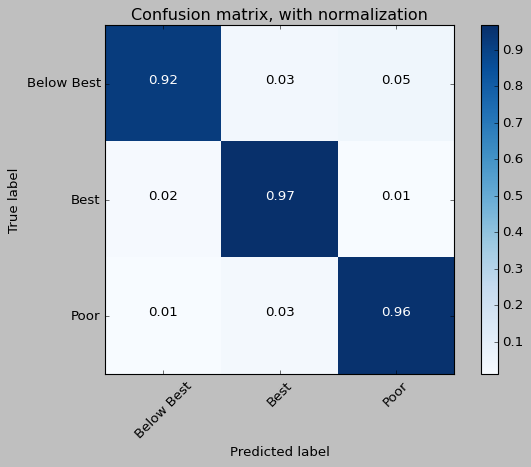

In [58]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(confusion, classes=['Below Best', 'Best', 'Poor'],
                      title='Confusion matrix, with normalization',
                      normalize = True,)
                    #   cmap = plt.cm.jet)

## WITHERED Data Training and Validation: 
Using Necessary Data Augmentation and DataGenerator to test the model

In [59]:
print(len(os.listdir('/content/Withered/Below Best')))
print(len(os.listdir('/content/Withered/Best')))
print(len(os.listdir('/content/Withered/Poor')))

279
269
273


Since there is not much imbalance among the Withered Dataset we can simply apply all the augmentation to all the classes for better generalization of the model.

In [60]:
seq1 = iaa.Sequential([
    iaa.Fliplr(1.0), 
    iaa.Flipud(0.7)
])

seq2 = iaa.Sequential([
    iaa.Affine(rotate=(-60, 60)),
    iaa.Flipud(1.0)
])

seq3 = iaa.PerspectiveTransform(scale=(0.01, 0.15))
seq4 = iaa.Affine(scale=(0.5, 1.5))
seq5 = iaa.LinearContrast((0.4, 1.6))
seq6 = iaa.Sequential([
    iaa.Flipud(1.0), 
    iaa.AllChannelsHistogramEqualization()
])
seq7 = iaa.LogContrast(gain=(0.6, 1.4))

''' Applying Augmentation for Best Class'''
count = 0
for i in os.listdir('/content/Withered/Best'):
    img = Image.open(os.path.join("/content/Withered/Best",i))
    img = np.array(img)

    img1 = seq2(image=img)
    img1 = Image.fromarray(np.uint8(img1)).convert('RGB')
    img1.save("/content/Withered/Best/img_{}.jpg".format(count))
    count += 1

    img2 = seq1(image=img)
    img2 = Image.fromarray(np.uint8(img2)).convert('RGB')
    img2.save("/content/Withered/Best/img_{}.jpg".format(count))
    count += 1

    img3 = seq3(image=img)
    img3 = Image.fromarray(np.uint8(img3)).convert('RGB')
    img3.save("/content/Withered/Best/img_{}.jpg".format(count))
    count += 1

    img4 = seq4(image=img)
    img4 = Image.fromarray(np.uint8(img4)).convert('RGB')
    img4.save("/content/Withered/Best/img_{}.jpg".format(count))
    count += 1

    img5 = seq5(image=img)
    img5 = Image.fromarray(np.uint8(img5)).convert('RGB')
    img5.save("/content/Withered/Best/img_{}.jpg".format(count))
    count += 1

    img6 = seq6(image=img)
    img6 = Image.fromarray(np.uint8(img6)).convert('RGB')
    img6.save("/content/Withered/Best/img_{}.jpg".format(count))
    count += 1

    img7 = seq7(image=img)
    img7 = Image.fromarray(np.uint8(img7)).convert('RGB')
    img7.save("/content/Withered/Best/img_{}.jpg".format(count))
    count += 1

''' Applying Augmentation for Below Best Class'''
count = 0
for i in os.listdir('/content/Withered/Below Best'):
    img = Image.open(os.path.join("/content/Withered/Below Best",i))
    img = np.array(img)

    img1 = seq2(image=img)
    img1 = Image.fromarray(np.uint8(img1)).convert('RGB')
    img1.save("/content/Withered/Below Best/img_{}.jpg".format(count))
    count += 1

    img2 = seq1(image=img)
    img2 = Image.fromarray(np.uint8(img2)).convert('RGB')
    img2.save("/content/Withered/Below Best/img_{}.jpg".format(count))
    count += 1

    img3 = seq3(image=img)
    img3 = Image.fromarray(np.uint8(img3)).convert('RGB')
    img3.save("/content/Withered/Below Best/img_{}.jpg".format(count))
    count += 1

    img4 = seq4(image=img)
    img4 = Image.fromarray(np.uint8(img4)).convert('RGB')
    img4.save("/content/Withered/Below Best/img_{}.jpg".format(count))
    count += 1

    img5 = seq5(image=img)
    img5 = Image.fromarray(np.uint8(img5)).convert('RGB')
    img5.save("/content/Withered/Below Best/img_{}.jpg".format(count))
    count += 1

    img6 = seq6(image=img)
    img6 = Image.fromarray(np.uint8(img6)).convert('RGB')
    img6.save("/content/Withered/Below Best/img_{}.jpg".format(count))
    count += 1

    img7 = seq7(image=img)
    img7 = Image.fromarray(np.uint8(img7)).convert('RGB')
    img7.save("/content/Withered/Below Best/img_{}.jpg".format(count))
    count += 1


''' Applying Augmentation for Poor Class'''
count = 0
for i in os.listdir('/content/Withered/Poor'):
    img = Image.open(os.path.join("/content/Withered/Poor",i))
    img = np.array(img)

    img1 = seq2(image=img)
    img1 = Image.fromarray(np.uint8(img1)).convert('RGB')
    img1.save("/content/Withered/Poor/img_{}.jpg".format(count))
    count += 1

    img2 = seq1(image=img)
    img2 = Image.fromarray(np.uint8(img2)).convert('RGB')
    img2.save("/content/Withered/Poor/img_{}.jpg".format(count))
    count += 1

    img3 = seq3(image=img)
    img3 = Image.fromarray(np.uint8(img3)).convert('RGB')
    img3.save("/content/Withered/Poor/img_{}.jpg".format(count))
    count += 1

    img4 = seq4(image=img)
    img4 = Image.fromarray(np.uint8(img4)).convert('RGB')
    img4.save("/content/Withered/Poor/img_{}.jpg".format(count))
    count += 1

    img5 = seq5(image=img)
    img5 = Image.fromarray(np.uint8(img5)).convert('RGB')
    img5.save("/content/Withered/Poor/img_{}.jpg".format(count))
    count += 1

    img6 = seq6(image=img)
    img6 = Image.fromarray(np.uint8(img6)).convert('RGB')
    img6.save("/content/Withered/Poor/img_{}.jpg".format(count))
    count += 1

    img7 = seq7(image=img)
    img7 = Image.fromarray(np.uint8(img7)).convert('RGB')
    img7.save("/content/Withered/Poor/img_{}.jpg".format(count))
    count += 1

print(len(os.listdir('/content/Withered/Below Best')))
print(len(os.listdir('/content/Withered/Best')))
print(len(os.listdir('/content/Withered/Poor')))

2232
2152
2184


In [61]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    shear_range=0.4,
    validation_split=0.2,
)

train_generator = datagen.flow_from_directory(
        '/content/Withered',
        target_size=(224, 224),
        batch_size=16,
        subset='training',
        class_mode='categorical')
validation_generator = datagen.flow_from_directory(
        '/content/Withered',
        target_size=(224, 224),
        batch_size=16,
        subset='validation',
        class_mode='categorical')

Found 5256 images belonging to 3 classes.
Found 1312 images belonging to 3 classes.


In [62]:
trainer = Customed_datagen(train_generator)
validator = Customed_datagen(validation_generator)

In [63]:
# we simply fine-tune on weights from FRESH model
M.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])
history = M.fit(trainer, validation_data= validator, epochs = 26)

Epoch 1/26
329/329 [==============================] - 338s 902ms/step - loss: 0.9200 - accuracy: 0.5573 - val_loss: 0.8628 - val_accuracy: 0.5976
Epoch 2/26
329/329 [==============================] - 289s 879ms/step - loss: 0.7159 - accuracy: 0.6865 - val_loss: 0.7827 - val_accuracy: 0.6631
Epoch 3/26
329/329 [==============================] - 289s 878ms/step - loss: 0.6102 - accuracy: 0.7662 - val_loss: 0.7073 - val_accuracy: 0.7058
Epoch 4/26
329/329 [==============================] - 288s 874ms/step - loss: 0.5414 - accuracy: 0.8183 - val_loss: 0.6459 - val_accuracy: 0.7546
Epoch 5/26
329/329 [==============================] - 287s 873ms/step - loss: 0.4956 - accuracy: 0.8497 - val_loss: 0.6177 - val_accuracy: 0.7630
Epoch 6/26
329/329 [==============================] - 289s 878ms/step - loss: 0.4614 - accuracy: 0.8702 - val_loss: 0.5948 - val_accuracy: 0.7721
Epoch 7/26
329/329 [==============================] - 289s 878ms/step - loss: 0.4232 - accuracy: 0.8975 - val_loss: 0.5672 -

changing the optimizer to see any improvements

In [65]:
M.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5), metrics=['accuracy'])
history_1 = M.fit(trainer, validation_data= validator, epochs = 4)

Epoch 1/4
329/329 [==============================] - 372s 910ms/step - loss: 0.1781 - accuracy: 0.9930 - val_loss: 0.2319 - val_accuracy: 0.9611
Epoch 2/4
329/329 [==============================] - 290s 881ms/step - loss: 0.1703 - accuracy: 0.9943 - val_loss: 0.2342 - val_accuracy: 0.9596
Epoch 3/4
329/329 [==============================] - 291s 883ms/step - loss: 0.1657 - accuracy: 0.9945 - val_loss: 0.2313 - val_accuracy: 0.9611
Epoch 4/4
329/329 [==============================] - 290s 881ms/step - loss: 0.1615 - accuracy: 0.9949 - val_loss: 0.2322 - val_accuracy: 0.9588


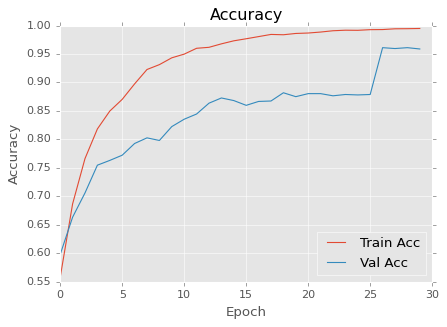

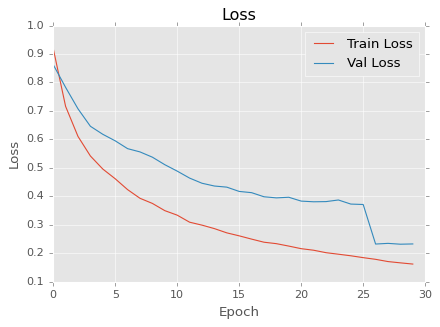

In [78]:
plt.style.use("ggplot")
fig = plt.gcf()
fig.set_size_inches(6, 4)

acc = history.history['accuracy'] + history_1.history['accuracy']
val_acc = history.history['val_accuracy'] + history_1.history['val_accuracy']
loss = history.history['loss'] + history_1.history['loss']
val_loss = history.history['val_loss'] + history_1.history['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Acc', 'Val Acc'], loc='lower right')
plt.show()

fig = plt.gcf()
fig.set_size_inches(6, 4)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Val Loss'])
plt.show()

### Evaluating Model Performance

In [79]:
val_gen = datagen.flow_from_directory(
        '/content/Withered',
        target_size=(224, 224),
        batch_size=1312,
        subset='validation',
        class_mode='categorical')

Found 1312 images belonging to 3 classes.


In [80]:
val_g = Customed_datagen(val_gen)
x,y = val_g[0]

In [81]:
predicted = M.predict(x)
predict = np.argmax(predicted, axis=1)
truth = np.argmax(y, axis=1)
errors = np.where(predict != truth)

In [82]:
print('No of errors = {}/{}'.format(len(errors[0]),len(truth)))

No of errors = 55/1312


In [83]:
y_test = truth
y_pred = predict
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Below Best', 'Best', 'Poor']))

Confusion Matrix

[[412  15  19]
 [  7 423   0]
 [ 12   2 422]]

Accuracy: 0.96


Classification Report

              precision    recall  f1-score   support

  Below Best       0.96      0.92      0.94       446
        Best       0.96      0.98      0.97       430
        Poor       0.96      0.97      0.96       436

    accuracy                           0.96      1312
   macro avg       0.96      0.96      0.96      1312
weighted avg       0.96      0.96      0.96      1312



Normalized confusion matrix
[[0.92 0.03 0.04]
 [0.02 0.98 0.  ]
 [0.03 0.   0.97]]


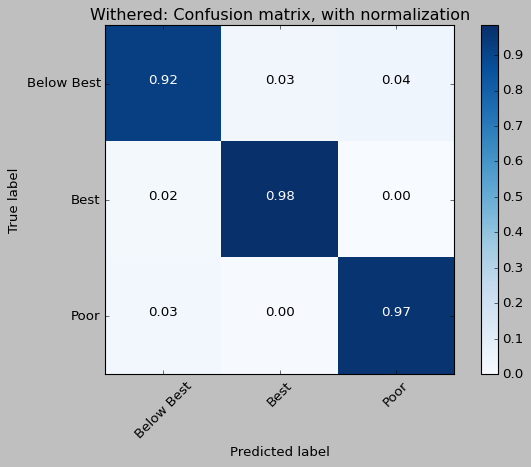

In [85]:
plt.style.use("classic")
plot_confusion_matrix(confusion, classes=['Below Best', 'Best', 'Poor'],
                      title='Withered: Confusion matrix, with normalization',
                      normalize = True,)